In [351]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from datetime import datetime
from datetime import timedelta
from magi_module import get_report

## Data set for ML

In [100]:
macro = pd.read_csv('./data/macro_data.csv', encoding='euc_kr')

In [101]:
a = macro.iloc[:1,:].T.iloc[1:,:]
Y_series = a[a[0]=='Y'].T.columns
Q_series = a[a[0]=='Q'].T.columns
M_series = a[a[0]=='M'].T.columns
D_series = a[a[0]=='D'].T.columns
macro = macro.drop(Y_series, axis=1).drop(Q_series, axis=1)
DDR_series = ['DDR4 16G (2G*8) 2666 MHZ(USD)', 'DDR4 16G (2G*8) eTT MHZ(USD)', 'DDR3 4Gb 512Mx8 1600/1866Mbps(USD)', 'DDR3 4Gb 512Mx8 eTT(USD)']
macro = macro.drop(DDR_series, axis=1)
D_series = D_series.drop(DDR_series)

In [102]:
macro_data = macro.iloc[1:7812,:]
date = pd.to_datetime(macro_data['Item Name'])
macro_data = macro_data.drop('Item Name', axis=1)
macro_data.set_index(date, inplace=True)
macro_data = macro_data.apply(pd.to_numeric)

In [103]:
 #미래참조 경향을 방지하기 위해 lag 취함
macro_lagged = macro_data.copy()
macro_lagged[M_series] = macro_data[M_series].shift(-30)
macro_lagged[D_series] = macro_data[D_series].shift(-1)

In [104]:
start = '2012-01-01'
macro_lagged = macro_lagged.loc[start:,:]
col_macro = macro_lagged.columns
macro_week = macro_lagged.resample('W').mean()
macro_week.describe()
ind_macro = pd.to_datetime(macro_week.index)

RobustScaler로 스케일 맞추기

In [105]:
transformer = RobustScaler().fit(macro_week)
macro_scaled = pd.DataFrame(transformer.transform(macro_week), columns=col_macro, index=ind_macro)

### Label

In [106]:
date_ind = macro_scaled.index
labels = pd.read_csv('./data label.csv')
labels = labels['012'].iloc[:len(date_ind)]

In [107]:
labels.index = date_ind
labels.value_counts() #0:상승 / 1:횡보 / 2:하락

0    206
2    151
1    136
Name: 012, dtype: int64

In [108]:
df = pd.merge(macro_week, labels, how='inner', left_index=True, right_index=True)
df.rename(columns={'012':'Position'}, inplace=True)
df

,선행종합지수(2015=100)(2015=100),선행종합지수 전월비(2015=100),재고순환지표(2015=100),경제심리지수(2015=100),수출입물가비율(2015=100)(2015=100),장단기금리차(2015=100),동행종합지수(2015=100)(2015=100),광공업생산지수(2015=100)(2015=100),동행종합지수 전월비(2015=100),동행지수 순환변동치(2015=100),...,납(선물)($/ton),니켈(선물)($/ton),주석(선물)($/ton),아연(선물)($/ton),한국(2015=100),미국(2015=100),일본(2015=100),영국(2015=100),독일(2015=100),Position
Item Name,,,,,,,,,,,,,,,,,,,,,
2012-01-01,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2003.000000,18255.000000,18925.000000,1845.000000,98.1,95.5,103.9,100.8,97.3,1
2012-01-08,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2010.142857,18641.428571,19742.142857,1851.071429,98.1,95.5,103.9,100.8,97.3,0
2012-01-15,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2019.071429,19523.571429,20809.285714,1942.071429,98.1,95.5,103.9,100.8,97.3,0
2012-01-22,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2148.285714,20011.428571,21875.714286,2020.000000,98.1,95.5,103.9,100.8,97.3,0
2012-01-29,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2283.714286,21272.142857,23503.571429,2152.785714,98.1,95.5,103.9,100.8,97.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2201.500000,17990.571429,33295.285714,2967.357143,NaN,NaN,NaN,NaN,NaN,0
2021-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2166.357143,17570.000000,32002.857143,2943.642857,NaN,NaN,NaN,NaN,NaN,0
2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2204.571429,17295.571429,32452.571429,2978.857143,NaN,NaN,NaN,NaN,NaN,0


In [186]:
df.tail(7)

,선행종합지수(2015=100)(2015=100),선행종합지수 전월비(2015=100),재고순환지표(2015=100),경제심리지수(2015=100),수출입물가비율(2015=100)(2015=100),장단기금리차(2015=100),동행종합지수(2015=100)(2015=100),광공업생산지수(2015=100)(2015=100),동행종합지수 전월비(2015=100),동행지수 순환변동치(2015=100),...,납(선물)($/ton),니켈(선물)($/ton),주석(선물)($/ton),아연(선물)($/ton),한국(2015=100),미국(2015=100),일본(2015=100),영국(2015=100),독일(2015=100),Position
Item Name,,,,,,,,,,,,,,,,,,,,,
2021-04-25,126.2,0.7,11.4,101.1,93.6,1.01,116.4,114.3,1.1,101.3,...,2020.357143,16162.428571,28076.285714,2813.357143,112.8,102.4,99.4,98.2,96.0,0
2021-05-02,126.2,0.7,11.4,101.1,93.6,1.01,116.4,114.3,1.1,101.3,...,2098.928571,17354.000000,31275.142857,2906.000000,112.8,102.4,99.4,98.2,96.0,2
2021-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2201.500000,17990.571429,33295.285714,2967.357143,NaN,NaN,NaN,NaN,NaN,0
2021-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2166.357143,17570.000000,32002.857143,2943.642857,NaN,NaN,NaN,NaN,NaN,0
2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2204.571429,17295.571429,32452.571429,2978.857143,NaN,NaN,NaN,NaN,NaN,0
2021-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2189.928571,17557.285714,32611.714286,3011.571429,NaN,NaN,NaN,NaN,NaN,1
2021-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Machine Learning (XGBoost)

In [311]:
X_train = df.drop('Position', axis=1).loc['2012-01-01':'2018-12-29':, :]
Y_train = df['Position'].loc['2012-01-01':'2018-12-29']

In [192]:
X_test=df.drop('Position', axis=1).loc['2018-12-30':'2021-05-31',:]
Y_test = df['Position'].loc['2018-12-30':'2021-05-31']

## out of sample 분류

In [52]:
from xgboost import XGBClassifier
import time
start = time.time() # 시작 시간 지정

xgb_model = XGBClassifier(random_state=12, learning_rate=0.001, n_estimators=1000, max_depth=7, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_test) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_test, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test, xgb_model_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 46.03 %
MSE: 1.49
F1-Score: 0.39
Time: 10.45 seconds


C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


## in sample 분류

In [54]:
from xgboost import XGBClassifier
import time
start = time.time() # 시작 시간 지정

xgb_model = XGBClassifier(random_state=12, learning_rate=0.001, n_estimators=1000, max_depth=7, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_train) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_train, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_train, xgb_model_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

[17:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 94.81 %
F1-Score: 0.95
Time: 10.08 seconds


C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


## GridSearchCV (Hyperparameter Tuning)

In [60]:
from sklearn.model_selection import GridSearchCV
start = time.time() # 시작 시간 지정
params = {
    'n_estimators': [1000, 2000, 3000, 4000, 5000], 
    'learning_rate': [0.1, 0.05, 0.01, 0.001], 
    'max_depth': [7, 8], 
    'random_state': [12]
}
#xgb는 학습시킬 때 xgb.train으로 시킨다!
grid_search = GridSearchCV(XGBClassifier(), params, cv=3, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

C:\Users\jky93\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.21856731244010738
{'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 5000, 'random_state': 12}
Time: 4241.67 seconds


In [61]:
from xgboost import XGBClassifier
import time
start = time.time() # 시작 시간 지정

xgb_model = XGBClassifier(random_state=12, learning_rate=0.001, n_estimators=5000, max_depth=8, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_test) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_test, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test, xgb_model_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

[19:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 48.41 %
F1-Score: 0.43
Time: 60.67 seconds


C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [62]:
from xgboost import XGBClassifier
import time
start = time.time() # 시작 시간 지정

xgb_model = XGBClassifier(random_state=12, learning_rate=0.001, n_estimators=10000, max_depth=8, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_test) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_test, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test, xgb_model_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

[20:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 51.59 %
F1-Score: 0.45
Time: 127.38 seconds


In [142]:
start = time.time() # 시작 시간 지정
params = {
    'n_estimators': [10000, 9000, 11000], 
    'learning_rate': [0.01, 0.001], 
    'max_depth': [9, 8, 10], 
    'random_state': [12]
}
#xgb는 학습시킬 때 xgb.train으로 시킨다!
grid_search = GridSearchCV(XGBClassifier(), params, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:08:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.20479777734819415
{'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 11000, 'random_state': 12}
Time: 7151.37 seconds


#### 결정 모델

In [190]:
X_train

,선행종합지수(2015=100)(2015=100),선행종합지수 전월비(2015=100),재고순환지표(2015=100),경제심리지수(2015=100),수출입물가비율(2015=100)(2015=100),장단기금리차(2015=100),동행종합지수(2015=100)(2015=100),광공업생산지수(2015=100)(2015=100),동행종합지수 전월비(2015=100),동행지수 순환변동치(2015=100),...,주요상품선물_전기동(선물)($/ton),납(선물)($/ton),니켈(선물)($/ton),주석(선물)($/ton),아연(선물)($/ton),한국(2015=100),미국(2015=100),일본(2015=100),영국(2015=100),독일(2015=100)
Item Name,,,,,,,,,,,,,,,,,,,,,
2012-01-01,86.800000,0.200000,-13.600000,101.400000,84.500000,0.250000,89.6,97.200000,-0.1,100.300000,...,7570.000000,2003.000000,18255.000000,18925.000000,1845.000000,98.100000,95.500000,103.900000,100.8,97.300000
2012-01-08,86.800000,0.200000,-13.600000,101.400000,84.500000,0.250000,89.6,97.200000,-0.1,100.300000,...,7565.571429,2010.142857,18641.428571,19742.142857,1851.071429,98.100000,95.500000,103.900000,100.8,97.300000
2012-01-15,86.800000,0.200000,-13.600000,101.400000,84.500000,0.250000,89.6,97.200000,-0.1,100.300000,...,7897.000000,2019.071429,19523.571429,20809.285714,1942.071429,98.100000,95.500000,103.900000,100.8,97.300000
2012-01-22,86.800000,0.200000,-13.600000,101.400000,84.500000,0.250000,89.6,97.200000,-0.1,100.300000,...,8265.714286,2148.285714,20011.428571,21875.714286,2020.000000,98.100000,95.500000,103.900000,100.8,97.300000
2012-01-29,86.800000,0.200000,-13.600000,101.400000,84.500000,0.250000,89.6,97.200000,-0.1,100.300000,...,8489.142857,2283.714286,21272.142857,23503.571429,2152.785714,98.100000,95.500000,103.900000,100.8,97.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-02,113.028571,0.028571,-6.214286,95.971429,94.042857,0.544286,110.7,106.328571,0.0,100.342857,...,6202.214286,1956.142857,11009.285714,18553.571429,2485.642857,105.328571,106.128571,104.185714,102.7,103.842857
2018-12-09,113.100000,0.100000,-6.500000,94.900000,94.400000,0.430000,110.7,105.900000,0.0,100.200000,...,6163.142857,1981.857143,10985.714286,18939.285714,2603.142857,104.400000,106.200000,104.400000,102.7,104.700000
2018-12-16,113.100000,0.100000,-6.500000,94.900000,94.400000,0.430000,110.7,105.900000,0.0,100.200000,...,6127.285714,1950.642857,10845.000000,19287.857143,2551.071429,104.400000,106.200000,104.400000,102.7,104.700000


In [193]:
###########결정모델

start = time.time() # 시작 시간 지정

xgb_model = XGBClassifier(random_state=12, learning_rate=0.001, n_estimators=11000, max_depth=9, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_test) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_test, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test, xgb_model_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

[10:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jky93\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Accuracy: 45.67 %
F1-Score: 0.47
Time: 241.79 seconds


In [278]:
prediction = pd.DataFrame(xgb_model_predict, index=Y_test.index, columns=['prediction'])
prediction.loc['2019-09-10':'2020-07-03'] #0:상승, 1:횡보, 2:하락

,prediction
Item Name,
2019-09-15,0
2019-09-22,0
2019-09-29,2
2019-10-06,0
2019-10-13,0
2019-10-20,2
2019-10-27,2
2019-11-03,2
2019-11-10,2


In [200]:
prediction['prediction'].value_counts()

0    52
2    46
1    29
Name: prediction, dtype: int64

In [321]:
predict = prediction.copy().resample('d').first()
predict.loc[pd.to_datetime('2021-05-31')]=predict.loc['2021-05-30']
predict = predict.fillna(method='ffill', limit=6)
predict['prediction'].value_counts()

0.0    364
2.0    322
1.0    198
Name: prediction, dtype: int64

In [322]:
predict

,prediction
Item Name,
2018-12-30,1.0
2018-12-31,1.0
2019-01-01,1.0
2019-01-02,1.0
2019-01-03,1.0
...,...
2021-05-27,1.0
2021-05-28,1.0
2021-05-29,1.0


In [323]:
upward=predict[predict==0].dropna().index
downward=predict[predict==2].dropna().index
sideway = predict[predict==1].dropna().index
##리스트에 어떤 전략을 써야할 날짜인지, 날짜인지를 리스트에 추가시키고, 해당 날짜가 ''2012-05-11' in upward list가 True라면 상승전략 시행

해당 날짜가 0이면 이전 날짜까지의 데이터를 활용해서 듀얼모멘텀 스코어 구하기  
해당 날짜가 1이면 이전 날짜까지의 데이터를 활용해서 괴리율 전략  
해당 날짜가 2이면 이전 날짜까지의 데이터를 활용해서 카나리아전략

## 괴리율 전략

In [277]:
price_deviation = pd.read_csv('./price_deviation.csv', encoding = 'euc_kr')
price_deviation['tdate'] = pd.to_datetime(price_deviation['tdate'])
price_deviation = price_deviation.set_index('tdate').drop('Unnamed: 0', axis=1)

ind = price_deviation.index
col = price_deviation.columns

scale = RobustScaler()
price_deviation_scaled =pd.DataFrame(scale.fit_transform(price_deviation), index=ind, columns=col)
price_deviation_scaled

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387270.1,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2006-06-27,0.560976,-0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-28,0.097561,0.275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-29,-0.048780,0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-30,0.560976,1.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-03,0.073171,0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.756098,0.850,0.500,-0.608696,0.886792,0.166667,-1.670732,-0.421053,0.214286,-0.148936,...,-0.423077,-0.105263,-0.159624,0.21875,0.603774,-0.952381,-0.734177,-2.078947,-2.078947,1.00
2021-05-26,0.512195,-0.100,-0.225,-0.521739,0.867925,-0.333333,-1.097561,0.263158,-0.142857,-0.138298,...,-0.025641,0.593567,0.389671,0.37500,0.528302,-0.285714,-0.278481,-0.789474,-0.789474,1.75
2021-05-27,0.097561,-0.150,0.225,-0.434783,0.698113,0.000000,0.012195,1.210526,-0.892857,0.489362,...,0.500000,0.096491,0.300469,-0.50000,1.509434,1.333333,0.506329,0.000000,0.000000,0.00


## 듀얼모멘텀 전략

In [331]:
etf_data = pd.read_csv('./data/etf_data.csv', encoding = 'euc_kr')
etf_data['tdate'] = pd.to_datetime(etf_data['tdate'])
etf_ohlcv = etf_data.set_index(['tdate', 'etf_code', 'data_name'])['value'].unstack()
etf_close = etf_ohlcv['종가'].unstack()

In [343]:
new = etf_close[datetime(2018,12,31)-timedelta(days=370):datetime(2021,5,31)]
def get_momentum(x): 
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before2w = new[x.name-timedelta(days=20):x.name-timedelta(days=15)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1] 
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1) 
    except: 
        pass
    return momentum

momentum = new.apply(lambda x: get_momentum(x), axis=1)
momentum

etf_code,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2017-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.694396,-0.771958,1.495913,-0.133227,0.789836,-0.006821,0.157579,0.021207,-0.084878,1.096701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,0.496924,-0.407772,1.532570,-0.108845,0.231173,-0.008348,0.524589,-0.018267,-0.027962,1.242801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,0.403427,0.060483,1.762536,0.073329,0.495071,0.018742,0.659711,-0.249393,0.415186,0.931338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 카나리아 전략

In [346]:
defensive_etf = ["A174350", "A302190", "A237440", "A319640", "A305080"]
#방어 종목 선정 기준 강화 필요
inverse_etf = ["A217770", "A252710", "A123310"]
canary_etf = ["A117690", "A245360"]

# 카나리아 둘다 모멘텀이 0.5 이하 --> 방어 자산군에 가중치 부여
# 카나리아 둘다 모멘텀이 -1 이하 --> 인버스 및 방어 자산군에 가중치 부여
def DAA(x):
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before2w = new[x.name-timedelta(days=20):x.name-timedelta(days=15)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1] 
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1) 
        
        if momentum["A117690"] < -1 or momentum["A245360"] < -1:
            momentum["A302190"] += 2
            momentum["A237440"] += 2
            momentum["A319640"] += 2
            momentum["A250780"] += 2
#             if momentum["A117690"] < -1 or momentum["A245360"] < -1:
#                 momentum["A217770"] += 3
#                 momentum["A252710"] += 3
#                 momentum["A123310"] += 3
#                 momentum["A123310"] += 3
#         elif momentum["A117690"] > 0.75 and momentum["A245360"] > 0.75:
#             momentum["A233160"] += 2
#             momentum["A123320"] += 2
#             momentum["A204480"] += 2
#             momentum["A225040"] += 2
#             momentum["A225060"] += 2
            
    except:
        pass
    return momentum
    
canary = new.apply(lambda x: DAA(x), axis=1)
canary

etf_code,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2017-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.694396,-0.771958,1.495913,-0.133227,0.789836,-0.006821,0.157579,0.021207,-0.084878,1.096701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,0.496924,-0.407772,1.532570,-0.108845,0.231173,-0.008348,0.524589,-0.018267,-0.027962,1.242801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,0.403427,0.060483,1.762536,0.073329,0.495071,0.018742,0.659711,-0.249393,0.415186,0.931338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 스코어 구하기

In [324]:
score_ind = pd.DatetimeIndex(price_deviation_scaled['2018-12-30':'2021-05-31'].index)
score_col = price_deviation_scaled.columns

In [325]:
score = pd.DataFrame(np.NaN, index=score_ind, columns=score_col)
score

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387270.1,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
for date in predict.index:
    if date not in score.index:
        continue
    else:
        if date in upward:  #상승장에는 듀얼모멘텀
            score.loc[date,:] = momentum.loc[date,:]
        elif date in sideway:  #횡보장에는 괴리율전략
            score.loc[date,:] = price_deviation_scaled.loc[date,:]
        elif date in downward:   #하락장에는 카나리아전략
            score.loc[date,:] = canary.loc[date,:]
    
# if 
# price_deviation_daily_score = price_deviation_scaled.resample(resampling).first().loc[]

In [348]:
score

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387270.1,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.121951,-0.250,0.750,-0.173913,0.273585,0.166667,-0.158537,0.631579,-0.857143,1.425532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.097561,-0.050,-1.075,0.173913,0.037736,-1.000000,0.402439,-0.263158,0.321429,1.989362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.219512,-0.125,0.625,0.043478,-0.103774,0.333333,0.365854,-0.578947,0.250000,-0.287234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,-0.219512,0.750,0.500,-0.173913,0.990566,-0.500000,-0.280488,-0.210526,1.000000,-1.329787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,-0.243902,0.150,-0.125,-0.043478,1.415094,0.166667,0.158537,-0.210526,0.678571,0.053191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.756098,0.850,0.500,-0.608696,0.886792,0.166667,-1.670732,-0.421053,0.214286,-0.148936,...,-0.423077,-0.105263,-0.159624,0.21875,0.603774,-0.952381,-0.734177,-2.078947,-2.078947,1.00
2021-05-26,0.512195,-0.100,-0.225,-0.521739,0.867925,-0.333333,-1.097561,0.263158,-0.142857,-0.138298,...,-0.025641,0.593567,0.389671,0.37500,0.528302,-0.285714,-0.278481,-0.789474,-0.789474,1.75
2021-05-27,0.097561,-0.150,0.225,-0.434783,0.698113,0.000000,0.012195,1.210526,-0.892857,0.489362,...,0.500000,0.096491,0.300469,-0.50000,1.509434,1.333333,0.506329,0.000000,0.000000,0.00


,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,0.798157,1.073572,1.375084,1.801495,2.547115,2.811731,2.459663
MDD,-0.503605,-0.368461,-0.327462,-0.255627,-0.142482,-0.333522,-0.258961
TURNOVER,169.105438,266.125283,293.575180,275.996867,169.295636,338.401074,282.225997
CAGR,-0.072396,0.023946,0.112013,0.216777,0.365682,0.411425,0.349870
SHARPE,-0.065615,0.057042,0.188532,0.357840,0.494608,0.352374,0.376787


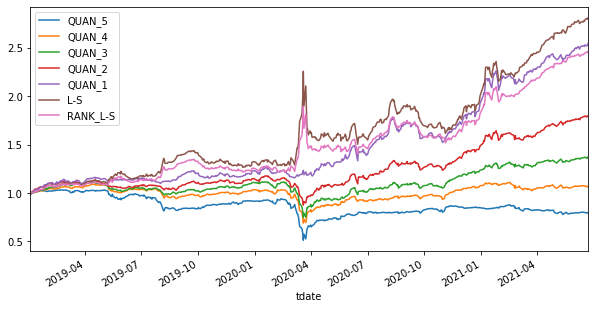

In [382]:
summ, ress = get_report(score)
ress.plot(figsize = (10, 5))
summ

In [384]:
submission = score.stack()

submission = submission.reset_index()
submission.columns = ['tdate', 'code', 'score']
submission.to_csv('./2021_final_score.csv')

In [387]:
def long_only_sig_to_weight(sig_series, sig, weight):
    long_count = (sig_series == sig).sum()
    
    if (long_count != 0):
        sig_series.loc[(sig_series != sig)] = np.NaN
        sig_series.loc[sig_series == sig] = weight / long_count
    else:
        sig_series.loc[:] = np.NaN
    
    return sig_series.fillna(0.)

def lower_turnover(score, target_start_date, target_end_date, threshold, resampling):
    ## 각 날짜별 quan1부터 quan5까지 나누기
    score= score.loc[target_start_date : target_end_date]
    sig_data = score.rank(1, 'first').apply(lambda x : pd.qcut(x, 5, labels = False,) if not x.isnull().all() else x, 1)
    delete = []

    for signal in range(5):
        name = f'quan_{signal}'  #동일비중 포트폴리오 구성
        weight_sig_data = sig_data.copy().apply(long_only_sig_to_weight, axis=1, args=(signal, 1))
        port = weight_sig_data.fillna(0)

        turnover = weight_sig_data.diff()  # turnover 계산1 --> weight의 변화분 찾는 것. weight가 변했다 = 그 주식을 매매했다 (포트에서 비중이 변동됨)
        turnover.iloc[0] = weight_sig_data.iloc[0]

        #turnover 계산2 --> 특정날짜의 weight 변동값의 절대값을 모든 ETF에 대해 더하고 2로 나눠서 (왜냐하면 더하고 뺀 값 중복을 방지하기 위해) 다시 모든 날짜에 대해 더해서 하나의 scalar값으로 나오게끔함
        TO = (abs(turnover).sum(1) / 2)
        delete_sub= []

        for i in range(len(TO)-1):
            if TO.iloc[i] < threshold: #특정날짜의 weight 변동값의 절대값 합이 작은 경우 해당 날짜를 score에서 제외시킴. (리밸런싱 안 함)
                delete_sub.append(i)
        delete.append(delete_sub)

    c = set(delete[0])
    for i in delete:
        for j in delete:
            if i != j:
                b= set(i).intersection(j)
                c = set(c).union(b)
            else:
                continue

    delete_common = list(c)
    print('delete common is', delete_common)
    
    global score_threshold
    score_threshold = score.drop(score.index[delete_common], axis=0)

    price_deviation_daily_score = score_threshold.resample(resampling).first()
    daily_summary, daily_ress = get_report(price_deviation_daily_score)


    return (daily_summary, daily_ress)


In [388]:
lower_turnover(score, '2018-12-31', '2021-05-31', 0.3, 'D')

delete common is [19, 20, 21, 22, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 274, 275, 276, 277, 278, 279,

(              QUAN_5      QUAN_4      QUAN_3      QUAN_2      QUAN_1  \
 RETURN      1.071239    1.200255    1.419446    1.623012    1.903143   
 MDD        -0.113789   -0.076584   -0.046102   -0.045182   -0.050972   
 TURNOVER  149.404572  155.798276  160.421186  160.298619  146.890463   
 CAGR        0.023204    0.062734    0.123845    0.175188    0.239245   
 SHARPE      0.099717    0.261332    0.443647    0.539746    0.686120   
 
                  L-S    RANK_L-S  
 RETURN      1.771379    1.647836  
 MDD        -0.085718   -0.072301  
 TURNOVER  296.295035  118.022512  
 CAGR        0.209959    0.181149  
 SHARPE      0.717762    0.726327  ,
               QUAN_5    QUAN_4    QUAN_3    QUAN_2    QUAN_1       L-S  \
 tdate                                                                    
 2019-01-02  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
 2019-01-03  0.989882  0.991283  0.992451  0.999703  0.997922  1.008040   
 2019-01-04  0.992622  1.001217  0.998196  

In [ ]:
submission = score_threshold.stack()

submission = submission.reset_index()
submission.columns = ['tdate', 'code', 'score']
submission.to_csv('./2021 빅페_미래에셋자산운용_score.csv')

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,0.750265,1.028464,1.451050,1.845708,2.667213,3.262034,2.715396
MDD,-0.458254,-0.350179,-0.324678,-0.284893,-0.160006,-0.220015,-0.170430
TURNOVER,113.942884,130.841118,139.048904,135.247311,110.085896,224.028780,190.008629
CAGR,-0.091333,0.009399,0.132124,0.226651,0.386817,0.483074,0.395118
SHARPE,-0.109595,0.033316,0.220922,0.342010,0.537830,0.458937,0.480378


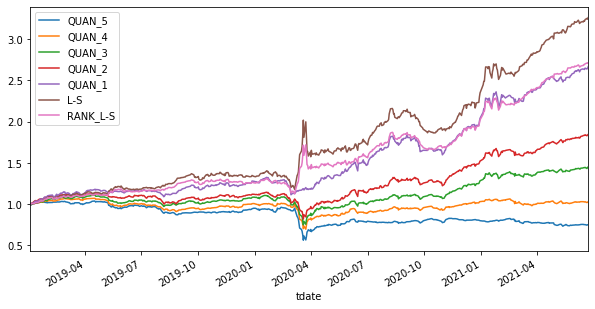

In [389]:
summ, ress = get_report(score_threshold)
ress.plot(figsize = (10, 5))
summ

In [369]:
lower_turnover(score, '2018-12-31', '2021-05-31', 0.2, 'D')

delete common is [20, 22, 28, 31, 33, 34, 35, 36, 40, 41, 44, 45, 46, 47, 49, 53, 61, 62, 63, 64, 65, 66, 68, 71, 74, 75, 76, 77, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 107, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 172, 173, 174, 175, 176, 177, 179, 181, 182, 184, 190, 192, 193, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 220, 222, 223, 224, 225, 226, 227, 228, 229, 231, 233, 234, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 249, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 311, 318, 319, 320, 321, 322, 323, 326, 327, 330, 332, 335, 336,

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,1.124276,1.226216,1.579071,1.890555,2.303590,2.038488,1.888139
MDD,-0.113789,-0.076584,-0.046102,-0.045182,-0.058125,-0.126239,-0.093775
TURNOVER,204.529464,217.398083,222.553015,220.248562,200.057130,404.586593,129.060854
CAGR,0.039819,0.070341,0.164485,0.236507,0.320693,0.267952,0.235980
SHARPE,0.136623,0.249430,0.505371,0.627377,0.726422,0.705268,0.738805


In [370]:
lower_turnover(score, '2018-12-31', '2021-05-31', 0.25, 'D')

delete common is [20, 21, 22, 28, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 74, 75, 76, 77, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 189, 190, 191, 192, 193, 196, 197, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 29

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,1.042224,1.154130,1.432914,1.698675,1.978818,1.892915,1.767781
MDD,-0.113789,-0.076584,-0.046102,-0.045182,-0.067953,-0.079922,-0.058813
TURNOVER,171.748079,181.075902,186.418680,184.700191,168.086134,339.834212,123.651209
CAGR,0.013881,0.048942,0.127388,0.193173,0.255457,0.237021,0.209139
SHARPE,0.057515,0.188168,0.419880,0.552589,0.639836,0.732194,0.752354


In [371]:
lower_turnover(score, '2018-12-31', '2021-05-31', 0.35, 'D')

delete common is [19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 263, 264, 265, 26

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,0.993089,1.107045,1.260078,1.435283,1.668418,1.676387,1.566594
MDD,-0.113789,-0.076584,-0.046102,-0.045182,-0.047104,-0.044298,-0.041868
TURNOVER,129.010849,134.057424,138.575823,138.615411,127.427909,256.438758,114.887452
CAGR,-0.002309,0.034479,0.080105,0.128009,0.186046,0.187932,0.161410
SHARPE,-0.002982,0.155033,0.327523,0.438168,0.602199,0.762852,0.765979


Macro 데이터 있는 날짜까지만 돌리기

In [115]:
X_test_full=df.drop('Position', axis=1).loc['2018-12-31':'2021-05-02',:]
Y_test_full = df['Position'].loc['2018-12-31':'2021-05-02']

In [65]:
from xgboost import XGBClassifier
import time
start = time.time() # 시작 시간 지정

xgb_model = XGBClassifier(random_state=12, learning_rate=0.001, n_estimators=10000, max_depth=8, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_test_full) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_test_full, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test_full, xgb_model_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

[21:14:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 52.46 %
F1-Score: 0.45
Time: 133.18 seconds


## Machine Learning (RandomForest)
랜덤포레스트는 NA있으면 안 되네..

In [133]:
from sklearn.ensemble import RandomForestClassifier
start = time.time()
rf = RandomForestClassifier(n_estimators=10000,  max_depth = 8, random_state=12, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, Y_train)
rf_predict = rf.predict(X_test_full)
print("Accuracy: %.2f" % (accuracy_score(Y_test_full, rf_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test_full, rf_predict, average='weighted')))
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산


Accuracy: 49.18 %
F1-Score: 0.35
Time: 14.07 seconds


In [140]:
from sklearn.model_selection import GridSearchCV
start = time.time() # 시작 시간 지정
params = {
    'n_estimators': [10000, 3000, 4000, 5000], 
    'max_depth': [7, 8, 9], 
    'random_state': [12],
    'class_weight': ['balanced']
}
#xgb는 학습시킬 때 xgb.train으로
grid_search = GridSearchCV(RandomForestClassifier(), params, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
print("Time: %.2f" % (time.time() - start), "seconds") # 코드 실행 시간 계산

0.17747694927536337
{'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 10000, 'random_state': 12}
Time: 242.53 seconds


따라서 RandomForest보다는 XGBoost가 더 낫다